### setup

In [1]:
from cvxpy import *
from datetime import datetime
from EbolaSimulator import*
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time

%matplotlib inline

%load_ext autoreload
%autoreload 2

### load graph model from file

In [2]:
graph = pickle.load(open(os.getcwd()+'/ebola_graph.pkl' ,'rb'))

### run simulations

In [3]:
# simulation parameters
# alpha = 0.7
alpha = 0.14
beta = 1/1.17
eta = 0
# eta = 0.10
# alpha = 1/1.17
# beta = 1
# eta = 0
parameters = {}
parameters['alpha'] = alpha
parameters['beta'] = beta
parameters['eta'] = eta

init = {}
init[('guinea','gueckedou')] = 1

plot_data = {}
trigger = 55

mean infection time: 37.58
median infection time: 38.00


{'boxes': [<matplotlib.lines.Line2D at 0x7f1fbf47ca90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1fbf487e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1fbf499ef0>],
 'means': [<matplotlib.lines.Line2D at 0x7f1fbf499748>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1fbf492ef0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f201340bf98>,
  <matplotlib.lines.Line2D at 0x7f1fbf487cf8>]}

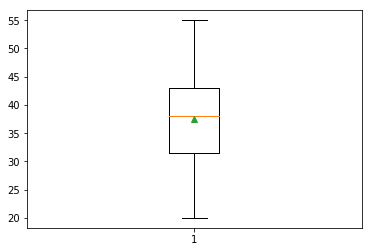

In [4]:
sim = EbolaSimulator(graph, init, parameters, rng=1)
for k in sim.states.keys():
    plot_data[k] = []
    plot_data[k].append(sim.states[k]['value'])
    
while not sim.end:
    action = []
    if sim.iter >= trigger:
        for k in graph.keys():
            action.append(k)
        
    sim.step(action)
    for k in sim.states.keys():
        plot_data[k].append(sim.states[k]['value'])
    
#for k in sorted(sim.states.keys()):
#    print('%03d : %s %s' %(sim.states[k]['value'],k,sim.states[k]['status']))

dt = [sim.states[k]['value'] for k in sim.states.keys()]
print('mean infection time: %0.2f' %np.mean(dt))
print('median infection time: %0.2f' %np.median(dt))

plt.boxplot(dt, showmeans=True)

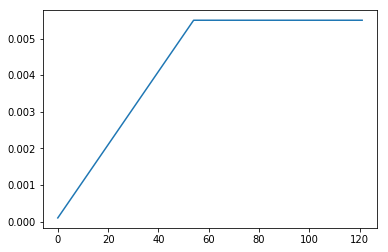

In [5]:
k = ('liberia','montserrado')
k = ('guinea','gueckedou')
t = [t for t in range(len(plot_data[k]))]
v = [0.0001*el for el in plot_data[k]]
plt.plot(t, v)

check statistics for simulation run many times

In [52]:
st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()
dt_list = []
for s in range(1000):
    sim = EbolaSimulator(graph, init, parameters, rng=s+1000)

    while not sim.end:
        action = []
        if sim.iter >= trigger:
            for k in graph.keys():
                action.append(k)

        sim.step(action)
        
    dt = [sim.states[k]['value'] for k in sim.states.keys()]
    dt_list.append(np.mean(dt))


st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-15 22:57:06] start
[2018-03-15 22:57:18] finish
12.70s = 0.21m elapsed


In [53]:
print('average dT over %d runs: %0.2f' %(len(dt_list),np.mean(dt_list)))

average dT over 1000 runs: 37.72


### approximate value function method

basis functions: $w_{0} + w_{1}\textbf{1}_{s}(x_{e}^{t}) + w_{2}\textbf{1}_{s}(x_{i}^{t})\sum_{j\in N(i)}\textbf{1}_{i}(x_{j}^{t}) + w_{3}\textbf{1}_{r}(x_{i}^{t})$

reward: $r_{i} = \textbf{1}_{s}(1-\alpha e_{i}^{t+1}) + \sigma\textbf{1}_{e}(x_{i}^{t+1})$

In [6]:
gamma = 0.9

In [7]:
phi = Variable()
w = Variable(4)
objective = Minimize(phi)
constraints = []

sigma = -1
deg = 4
for i in [0,1,2]:
    if i == 0:
        
        for vi in range(deg+1):
            for ei in range(deg+1-vi):
                
                for ej_sum in range((deg-1)*vi+1):
                    for a in range(ei+1):
                        if a == 0:
                            constraints += [phi >= w[0] + w[1] + w[2]*ei - 
                                            (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*a)) - (sigma*alpha*ei) -
                                            gamma*w[0]-gamma*w[1]*(1-alpha*ei) - 
                                            gamma*w[2]*(1-alpha*ei)*(alpha*ej_sum+ei-beta*a) - 
                                            gamma*w[3]*alpha*ei]
                    
                        constraints += [phi >= -w[0] - w[1] - w[2]*ei + 
                                        (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*a)) + (sigma*alpha*ei) +
                                        gamma*w[0]-gamma*w[1]*(1-alpha*ei) +
                                        gamma*w[2]*(1-alpha*ei)*(alpha*ej_sum+ei-beta*a) +
                                        gamma*w[3]*alpha*ei]

    elif i == 1:
        
        for ei in range(deg+1):
            for a in [0,1]:

                if a == 0:
                    constraints += [phi >= w[0] + w[3] -
                                    (sigma*(1-beta*a)) - gamma*w[0] - gamma*w[3]*(1-beta*a)]
                    
                constraints += [phi >= -w[0] - w[3] +
                                (sigma*(1-beta*a)) + gamma*w[0] + gamma*w[3]*(1-beta*a)]
                
    elif i == 2:
        constraints += [phi >=  w[0] - gamma*w[0]]
        constraints += [phi >= -w[0] + gamma*w[0]]


problem = Problem(objective, constraints)
print('number of constraints: %d' %len(constraints))

number of constraints: 232


In [8]:
result = problem.solve(solver=ECOS)
print('problem status: %s' %problem.status)
print('error: %0.4f' %problem.value)
print('weight(s): ')
print(w.value)

problem status: optimal
error: 0.4916
weight(s): 
[[-4.91642085]
 [ 1.21939295]
 [-0.28271467]
 [-0.16715831]]


In [91]:
phi = Variable()
w = Variable(2)
objective = Minimize(phi)
constraints = []

constraints += [phi >=  w[0] - gamma*w[0]]
constraints += [phi >= -w[0] + gamma*w[0]]

constraints += [phi >=  w[0]+w[1] - 1 - gamma*w[0] - gamma*w[1]]
constraints += [phi >= -w[0]-w[1] + 1 + gamma*w[0] + gamma*w[1]]

problem = Problem(objective, constraints)
print('number of constraints: %d' %len(constraints))

result = problem.solve()
print('problem status: %s' %problem.status)
print('error: %0.4f' %problem.value)
print('weight(s): ')
print(w.value)

number of constraints: 4
problem status: optimal
error: 0.0000
weight(s): 
[[  3.25762458e-16]
 [  2.00000000e+01]]


In [32]:
def vw(states, graph, capacity, weights, alpha, beta, gamma, sigma):
    control = []
    for k in states.keys():
        if states[k]['status'] == 'infected':
            ni = 0
            for el in graph[k]['edges']:
                if states[el]['status'] == 'susceptible':
                    nj = 0
                    for ek in graph[el]['edges']:
                        if states[ek]['status'] == 'infected':
                            nj += 1
                    ni += (1-alpha*nj)
            
            value = (alpha + gamma*weights[2])*beta*ni - (sigma + gamma*weights[3])*beta
            control.append((value,k))
            
    control = sorted(control)[:capacity]
    control = [el[1] for el in control]
            
    return control


min infection time: 0.00
median infection time: 60.00
max infection time: 118.00


{'boxes': [<matplotlib.lines.Line2D at 0x7f1fbeb39470>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1fbeb4a978>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1fbec2b5c0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1fbf427b38>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1fbe880048>,
  <matplotlib.lines.Line2D at 0x7f1fbf43d588>]}

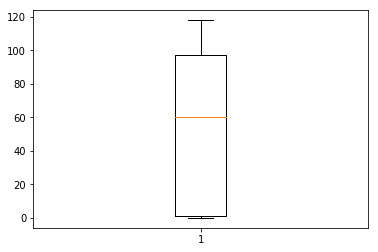

In [33]:
weights = [-4.91, 1.22, -0.28, -0.17]
capacity = 3

alpha = 0.14
beta = (1/1.17)*0.15
parameters = {}
parameters['alpha'] = alpha
parameters['beta'] = beta
parameters['eta'] = eta

trigger = 5

init = {}
init[('guinea','gueckedou')] = 1

sim = EbolaSimulator(graph, init, parameters, rng=1)

while not sim.end:
    action = []
    if sim.iter > trigger:
        action = vw(sim.states, graph, capacity, weights, alpha, beta, gamma, sigma)
        
    sim.step(action)
    
dt = [sim.states[k]['value'] for k in sim.states.keys()]
print('min infection time: %0.2f' %np.amin(dt))
print('median infection time: %0.2f' %np.median(dt))
print('max infection time: %0.2f' %np.amax(dt))

plt.boxplot(dt)

In [34]:
sim.states

{('guinea', 'beyla'): {'status': 'removed', 'value': 26},
 ('guinea', 'boffa'): {'status': 'removed', 'value': 15},
 ('guinea', 'boke'): {'status': 'removed', 'value': 16},
 ('guinea', 'conakry'): {'status': 'susceptible', 'value': 0},
 ('guinea', 'coyah'): {'status': 'removed', 'value': 1},
 ('guinea', 'dabola'): {'status': 'removed', 'value': 34},
 ('guinea', 'dalaba'): {'status': 'removed', 'value': 33},
 ('guinea', 'dinguiraye'): {'status': 'removed', 'value': 40},
 ('guinea', 'dubreka'): {'status': 'removed', 'value': 2},
 ('guinea', 'faranah'): {'status': 'removed', 'value': 67},
 ('guinea', 'forecariah'): {'status': 'removed', 'value': 47},
 ('guinea', 'fria'): {'status': 'removed', 'value': 27},
 ('guinea', 'gaoual'): {'status': 'removed', 'value': 6},
 ('guinea', 'gueckedou'): {'status': 'removed', 'value': 66},
 ('guinea', 'kankan'): {'status': 'removed', 'value': 59},
 ('guinea', 'kerouane'): {'status': 'removed', 'value': 65},
 ('guinea', 'kindia'): {'status': 'removed', 'v

benchmark vw method

In [35]:
trigger = 5

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()
dt_list = []
for s in range(1000):
    sim = EbolaSimulator(graph, init, parameters, rng=s+1000)

    while not sim.end:
        action = []
        if sim.iter >= trigger:
            action = vw(sim.states, graph, capacity, weights, alpha, beta, gamma, sigma)

        sim.step(action)
        
    dt = [sim.states[k]['value'] for k in sim.states.keys()]
    dt_list.append(np.median(dt))

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-16 20:42:45] start
[2018-03-16 20:43:02] finish
17.08s = 0.28m elapsed


min: 0.00
median: 17.25
max: 102.50


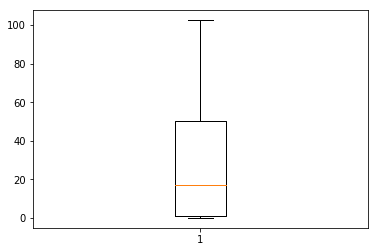

In [36]:
plt.boxplot(dt_list)

print('min: %0.2f' %np.amin(dt_list))
print('median: %0.2f' %np.median(dt_list))
print('max: %0.2f' %np.amax(dt_list))

### approximate Q function method

### implement and benchmark forsell et al. basis functions

In [29]:
phi = Variable()
w = Variable(3)
objective = Minimize(phi)
constraints = []

sigma = -1
deg = 4
for i in [0,1,2]:
    if i == 0:
        
        for vi in range(deg+1):
            for ei in range(deg+1-vi):
                
                for ej_sum in range((deg-1)*vi+1):
                    for a in range(ei+1):
                        
                        if i == 0:
                            constraints += [phi >= w[0] - 
                                            (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*a)) - (sigma*alpha*ei) - 
                                            gamma*w[0]*(1-alpha*ei) - gamma*w[1]*alpha*ei]
                        
                        constraints += [phi >= -w[0] + 
                                        (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*a)) + (sigma*alpha*ei) +
                                        gamma*w[0]*(1-alpha*ei) + gamma*w[1]*alpha*ei]
                        
    if i == 1:
        
        for ei in range(deg+1):
            for a in [0,1]:
                if a == 0:
                    constraints += [phi >= w[1] - 
                                    (sigma*(1-beta*a)) - gamma*w[1]*(1-beta*a) - gamma*w[2]*beta*a]
                    
                constraints += [phi >= -w[1] + 
                                (sigma*(1-beta*a)) + gamma*w[1]*(1-beta*a) + gamma*w[2]*beta*a]
                
    if i == 2:
        
        constraints += [phi >=  w[2] - gamma*w[2]]
        constraints += [phi >= -w[2] + gamma*w[2]]
                
        
problem = Problem(objective, constraints)
print('number of constraints: %d' %len(constraints))

number of constraints: 297


In [31]:
result = problem.solve()
print('problem status: %s' %problem.status)
print('error: %0.4f' %problem.value)
print('weight(s): ')
print(w.value)

problem status: optimal
error: 0.9475
weight(s): 
[[ 0.52450331]
 [-0.52450331]
 [-0.73672369]]


In [38]:
def priorwork(states, graph, capacity, weights, alpha, beta, gamma, sigma):
    control = []
    for k in states.keys():
        if states[k]['status'] == 'infected':
            ni = 0
            for el in graph[k]['edges']:
                if states[el]['status'] == 'susceptible':
                    nj = 0
                    for ek in graph[el]['edges']:
                        if states[ek]['status'] == 'infected':
                            nj += 1
                    ni += (1-alpha*nj)
            
            value = alpha*beta*ni + (-sigma*beta - gamma*weights[1]*beta + gamma*weights[2]*beta)
            control.append((value,k))
            
    control = sorted(control)[:capacity]
    control = [el[1] for el in control]
            
    return control

In [39]:
trigger = 5

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()
dt_list = []
for s in range(1000):
    sim = EbolaSimulator(graph, init, parameters, rng=s+1000)

    while not sim.end:
        action = []
        if sim.iter >= trigger:
            action = priorwork(sim.states, graph, capacity, weights, alpha, beta, gamma, sigma)

        sim.step(action)
        
    dt = [sim.states[k]['value'] for k in sim.states.keys()]
    dt_list.append(np.median(dt))

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-16 20:48:24] start
[2018-03-16 20:48:43] finish
18.67s = 0.31m elapsed


min: 0.00
median: 64.50
max: 106.00


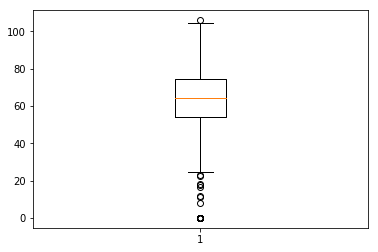

In [40]:
plt.boxplot(dt_list)

print('min: %0.2f' %np.amin(dt_list))
print('median: %0.2f' %np.median(dt_list))
print('max: %0.2f' %np.amax(dt_list))